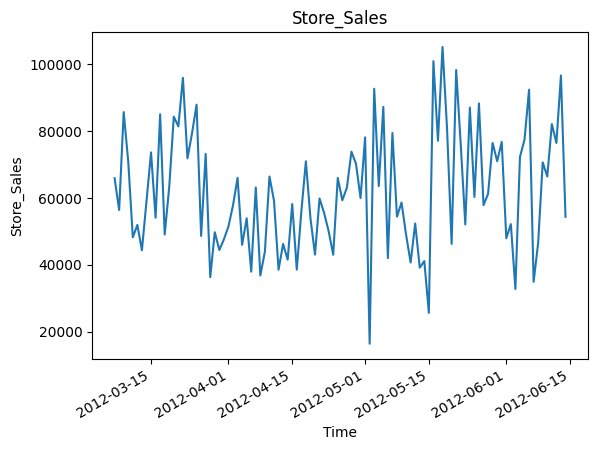

In [2]:
from time_series import TimeSeries

from statsmodels.tsa.holtwinters import ExponentialSmoothing

# imports for data visualization
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.dates import DateFormatter
from matplotlib import dates as mpld

from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()

ts = TimeSeries('./Stores.csv', train_size=0.7)
plt.plot(ts.data.iloc[-100:, 0].index, ts.data.iloc[-100:, 0])
plt.gcf().autofmt_xdate()
plt.title('Store_Sales')
plt.xlabel('Time')
plt.ylabel('Store_Sales')
plt.show()

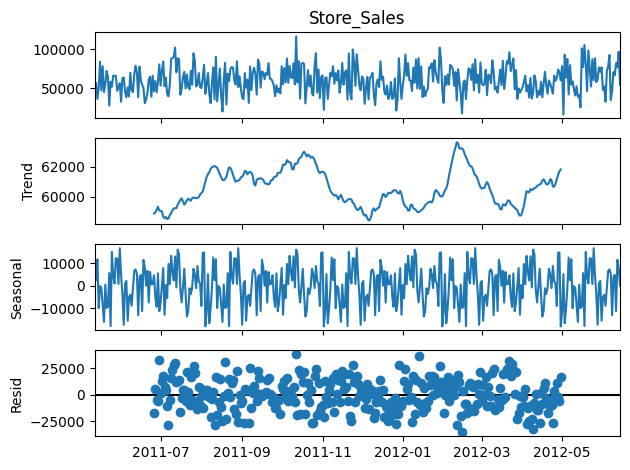

In [15]:
from statsmodels.tsa.seasonal import seasonal_decompose

seasonal_decompose(ts.data.iloc[-400:,0],model='additive',period=90).plot() # perid为周期时间
plt.show()

In [7]:
model = ExponentialSmoothing(
    ts.train, trend='additive', seasonal='additive').fit()
prediction = model.predict(
    start=ts.data.iloc[:, 0].index[0], end=ts.data.iloc[:, 0].index[-1])

"""Brutlag Algorithm"""
PERIOD = 12  # The given time series has seasonal_period=12
GAMMA = 0.3684211  # the seasonility component
SF = 1.96  # brutlag scaling factor for the confidence bands. # 置信区间
UB = []  # upper bound or upper confidence band
LB = []  # lower bound or lower confidence band
difference_array = []
dt = []
difference_table = {
    "actual": ts.data.iloc[:, 0], "predicted": prediction, "difference": difference_array, "UB": UB, "LB": LB}

"""Calculatation of confidence bands using brutlag algorithm"""
for i in range(len(prediction)):
    diff = ts.data.iloc[:, 0][i] - prediction[i]
    if i < PERIOD:
        dt.append(GAMMA * abs(diff))
    else:
        dt.append(GAMMA * abs(diff) + (1 - GAMMA) * dt[i - PERIOD])

    difference_array.append(diff)
    UB.append(prediction[i] + SF * dt[i])
    LB.append(prediction[i] - SF * dt[i])

print("\nDifference between actual and predicted\n")
difference = pd.DataFrame(difference_table)
print(difference)

"""Classification of data points as either normal or anomaly"""
normal = []
normal_date = []
anomaly = []
anomaly_date = []

for i in range(len(ts.data.iloc[:, 0].index)):
    if (UB[i] <= ts.data.iloc[:, 0][i] or LB[i] >= ts.data.iloc[:, 0][i]) and i > PERIOD:
        anomaly_date.append(ts.data.index[i])
        anomaly.append(ts.data.iloc[:, 0][i])
    else:
        normal_date.append(ts.data.index[i])
        normal.append(ts.data.iloc[:, 0][i])

anomaly = pd.DataFrame({"date": anomaly_date, "value": anomaly})
anomaly.set_index('date', inplace=True)
normal = pd.DataFrame({"date": normal_date, "value": normal})
normal.set_index('date', inplace=True)

print("\nThe data points classified as anomaly\n")
print(anomaly)

D:\conda\envs\timing_algorithm\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
D:\conda\envs\timing_algorithm\lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\yyx\AppData\Local\Temp\ipykernel_11216\632313523.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  diff = ts.data.iloc[:, 0][i] - prediction[i]
C:\Users\yyx\AppData\Local\Temp\ipykernel_11216\632313523.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value b


Difference between actual and predicted

            actual     predicted    difference             UB            LB
2010-01-01   66490  55970.874768  10519.125232   63566.791438  48374.958098
2010-01-02   39820  60253.748999 -20433.748999   75009.068594  45498.429404
2010-01-03   54010  56003.202927  -1993.202927   57442.505436  54563.900418
2010-01-04   53730  38545.615482  15184.384518   49510.340870  27580.890094
2010-01-05   46620  58114.422576 -11494.422576   66414.606683  49814.238470
...            ...           ...           ...            ...           ...
2012-06-10   66390  94666.762933 -28276.762933  136162.008307  53171.517559
2012-06-11   82080  90182.042405  -8102.042405  132086.178962  48277.905849
2012-06-12   76440  93859.585766 -17419.585766  125537.925188  62181.246344
2012-06-13   96610  97943.846307  -1333.846307  148058.151829  47829.540786
2012-06-14   54340  90844.051635 -36504.051635  153354.106632  28333.996637

[896 rows x 5 columns]

The data points class

C:\Users\yyx\AppData\Local\Temp\ipykernel_11216\632313523.py:40: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if (UB[i] <= ts.data.iloc[:, 0][i] or LB[i] >= ts.data.iloc[:, 0][i]) and i > PERIOD:
C:\Users\yyx\AppData\Local\Temp\ipykernel_11216\632313523.py:45: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  normal.append(ts.data.iloc[:, 0][i])
C:\Users\yyx\AppData\Local\Temp\ipykernel_11216\632313523.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, us

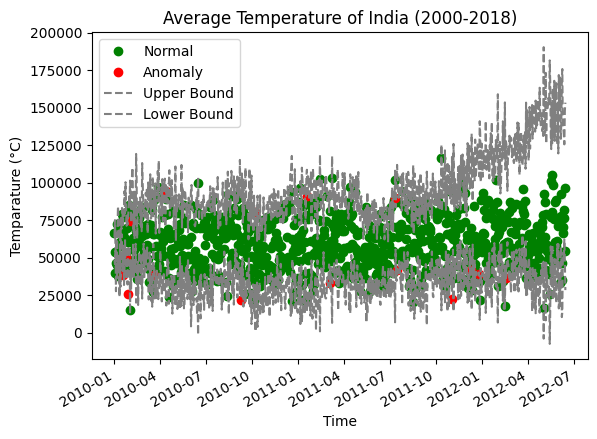

In [8]:
"""
Plotting the data points after classification as anomaly/normal.
Data points classified as anomaly are represented in red and normal in green.
"""
plt.plot(normal.index, normal, 'o', color='green')
plt.plot(anomaly.index, anomaly, 'o', color='red')

# Ploting brutlag confidence bands
plt.plot(ts.data.iloc[:, 0].index, UB, linestyle='--', color='grey')
plt.plot(ts.data.iloc[:, 0].index, LB, linestyle='--', color='grey')

# Formatting the graph
plt.legend(['Normal', 'Anomaly', 'Upper Bound', 'Lower Bound'])
plt.gcf().autofmt_xdate()
plt.title("Average Temperature of India (2000-2018)")
plt.xlabel("Time")
plt.ylabel("Temparature (°C)")
plt.show()